In [ ]:
# This is a pro-type notebook when I started the project, 
# with everything contained locally in this one notebook for running on Google Colab.
# Once I figured out how to run JupyterLab on Google Colab with multiple files, I split up the code.
# Main notebooks are now fitWithBasicNN.ipynb and fitWithCNN.ipynb.

In [ ]:
# # Import drive and connect
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Check GPU !nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
# import main modules
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(tf.config.list_physical_devices('GPU'))

2025-04-24 08:48:58.353442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# download and import packages for reading .tif files

# !pip install pyrsgis
# !pip install matplotlib_scalebar
from pyrsgis import raster
from pyrsgis.convert import changeDimension

In [66]:
# constants for program

main_bands = [i+1 for i in range(0,7)]
ndvi_band = 9
labels_band = 8


# choose the input band(s)
input_bands = ndvi_band
#input_bands = main_bands

print('Analyzing bands: ', input_bands)

# store the number of bands, which will be useful for inputting to the neural network later
if input_bands == ndvi_band: nBands = 1
else: nBands = len(main_bands)
print('nBands: ', nBands)


downsampleMajority = False

Analyzing bands:  9
nBands:  1


In [67]:
# define functions for use in the notebook - these should be moved to a separate file but making that work with colab is turning out to be a real headache

def removeOuterEdges(x):
    '''Something is off with the top row in the satellite data, and sometimes the other edges, remove them.'''
    if x.ndim == 2: 
        x = np.delete(x, [0, x.shape[0]-1], axis=0) # remove top and bottom edges
        x = np.delete(x, [0, x.shape[1]-1], axis=1) # remove left and right edges
    else: 
        x = np.delete(x, [0, x.shape[1]-1], axis=1) # remove top and bottom edges
        x = np.delete(x, [0, x.shape[2]-1], axis=2) # remove left and right edges

    return x

def normalizeBand(band):
    '''normalize band inputs to 0-1 for input into neural nets'''
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

def normalizeUInt16Band(band):
    '''Bands 1-7 are uint16, ranging from 0-65535, normalize them by dividing by the max.'''
    return band/65535.



In [68]:
# methods related to plotting - should be moved out into a separate file

# define colormap for plots
discrete_cmap = mpl.colors.ListedColormap(["red", "cornflowerblue", "gold", "olivedrab"], name="discrete_cmap")
vmin=-1
vmax=2

def plotNVDIBand(input_data):
    plt.figure(figsize=(24,6))
    plt.imshow(input_data, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

def plotMangroveBand(input_data):
    plt.figure(figsize=(16,6))
    plt.imshow(input_data, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
    # plt.colorbar()
    plt.show()

def plotDifference(labels_data, predicted_data):
    '''
    Plot difference in predicted (or future predicted) mangroves and labeled (past) mangroves.
    # multiply first array by 2 in order to get 4 values for difference plot:
    # pred - label -> output
    # 0 - 0 -> 0, predicted and label/past are not mangroves
    # 1 - 1 -> 1, predicted and label/past are mangroves
    # 1 - 0 -> 2, predicted was mangrove, label/past was not -> growth/false positive
    # 0 - 1 -> 0, predicted was not mangrove, label/past was -> loss/false negative
    '''

    image_difference = 2 * predicted_data - labels_data
    plt.figure(figsize=(24,6))
    plt.imshow(image_difference, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

In [69]:
# methods related to classification evaluation - should be moved out into a separate file

def printClassificationMetrics(y_actual, y_predicted_prob, input_prob=0.5):
    '''Print various classification metrics.'''

    y_predicted = (y_predicted_prob > input_prob).astype(int) # convert prediction probabilities to 0 or 1 values depending on threshold
    cMatrix = confusion_matrix(y_actual, y_predicted)
    pScore = precision_score(y_actual, y_predicted)
    rScore = recall_score(y_actual, y_predicted)
    aScore = accuracy_score(y_actual, y_predicted)
    f1Score = f1_score(y_actual, y_predicted)

    print("Confusion matrix:\n", cMatrix)
    print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))
    print('Accuracy: %.3f' % (aScore))
    print('f1: %.3f' % (f1Score))

    print(classification_report(y_actual, y_predicted))

def makeROCPlot(y_actual, y_predicted_prob):
    fpr, tpr, thresholds = roc_curve(y_actual, y_predicted_prob)
    auc_score = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()


In [70]:
# method for predicting on an image with the trained model
def predictOnImage(model, image):
  '''Take trained model and apply it to a new image.'''
  # read in band data
  ds_features_new, features_new = raster.read(image, bands=input_bands)
  ds_labels_new, labels_new = raster.read(image, bands=labels_band)

  # remove outer edges of data (which sometimes have issues)
  features_new = removeOuterEdges(features_new)
  labels_new = removeOuterEdges(labels_new)


  # fill NaNs with 0s
  features_new = np.nan_to_num(features_new)
  labels_new = np.nan_to_num(labels_new)

  # change label from float to int
  labels_new = (labels_new == 1).astype(int)

  # print('Check shapes:', features_new.shape, labels_new.shape)

  # plot NDVI band (if using it)
  if input_bands == ndvi_band: 
    print('\nNDVI band:')
    plotNVDIBand(features_new)

  # plot Mangrove band
  print('\nLabel mangroves from 2000 data:')
  plotMangroveBand(labels_new)

  # change dimensions of input
  features_new_input = changeDimension(features_new)
  labels_new_input = changeDimension(labels_new)

  # reshape it as an additional step for input into the NN
  features_new_input = features_new_input.reshape((features_new_input.shape[0], 1, nBands))
  # print('Check transformed shapes:', features_new_input.shape, labels_new_input.shape)

  # normalize bands for new image if using the main bands
  if input_bands == main_bands:
    features_new_input = normalizeUInt16Band(features_new_input)

  # predict on new image
  predicted_new_image_prob = model.predict(features_new_input)
  predicted_new_image_prob = predicted_new_image_prob[:,1]

  # print classification metrics
  probThresh = 0.5
  printClassificationMetrics(labels_new_input, predicted_new_image_prob, probThresh)
  makeROCPlot(labels_new_input, predicted_new_image_prob)

  # reshape prediction into 2D for plotting
  predicted_new_image_aboveThresh = (predicted_new_image_prob > probThresh).astype(int)
  prediction_new_image_2d = np.reshape(predicted_new_image_aboveThresh, (ds_labels_new.RasterYSize-2, ds_labels_new.RasterXSize-2)) # need the -2s since I removed the outer edges

  # plot predicted mangroves
  print('\nPredicted mangroves:')
  plotMangroveBand(prediction_new_image_2d)

  # plot difference in predicted and labeled, or future vs past labeled
  print('\nDifference between predicted and labeled mangroves:')
  plotDifference(labels_new, prediction_new_image_2d)


In [71]:
# Define the parameters of the model
if input_bands == ndvi_band:
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      # keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])
else:
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary)

<bound method Model.summary of <Sequential name=sequential_3, built=True>>


Shape: (9, 372, 372)
dtype: float32
min/max per band:
Band 1: (np.float32(-0.1105425), np.float32(0.573135))
Band 2: (np.float32(-0.01614875), np.float32(0.6364812))
Band 3: (np.float32(-0.0257325), np.float32(0.66788626))
Band 4: (np.float32(-0.0078575), np.float32(0.7005975))
Band 5: (np.float32(0.0014375), np.float32(0.7284825))
Band 6: (np.float32(295.9458), np.float32(320.1505))
Band 7: (np.float32(0.00196), np.float32(0.5284475))
Band 8: (np.float32(0.0), np.float32(1.0))
Band 9: (np.float32(-0.28425604), np.float32(0.5153897))


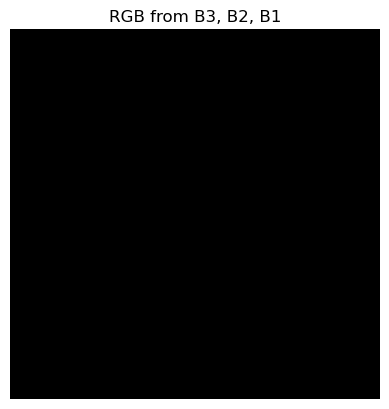

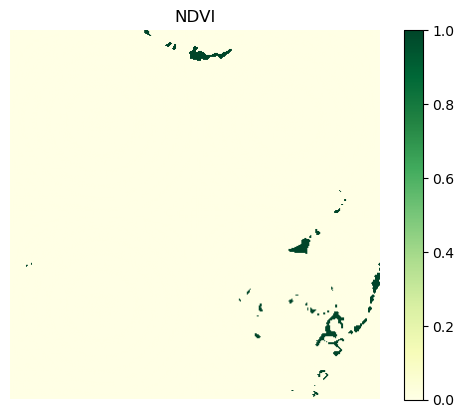

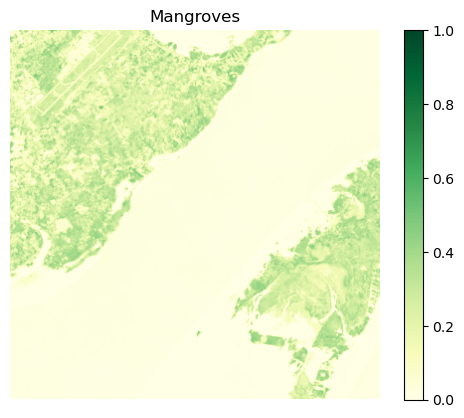

In [72]:
import rasterio
import numpy as np

tif_file = "../SatelliteImages/Olango_2_2020_L8_L7ordered_scaled.tif"
#tif_file = "../SatelliteImages/Florida_1_2000.tif"
# tif_file = "../SatelliteImages/Florida_1_2000_simple_composite.tif"

with rasterio.open(tif_file) as src:
    arr = src.read()  # shape: (bands, height, width)
    profile = src.profile
    print("Shape:", arr.shape)
    print("dtype:", arr.dtype)
    print("min/max per band:")
    for i in range(arr.shape[0]):
        print(f"Band {i+1}: {np.nanmin(arr[i]), np.nanmax(arr[i])}")


import matplotlib.pyplot as plt
# from pyrsgis import raster

# ds, arr = raster.read(tif_file)
# RGB確認（Red = Band 3, Green = Band 2, Blue = Band 1）
rgb = arr[[2, 1, 0], :, :]  # band順：B3, B2, B1
rgb = np.transpose(rgb, (1, 2, 0)) / 3000  # 私のファイルはスケーリングしてあるので正規化不要（この筆者のは必要）
plt.imshow(np.clip(rgb, 0, 1))
plt.title("RGB from B3, B2, B1")
plt.axis("off")
plt.show()

# NDVIはバンド7（0-indexed）
ndvi = arr[7, :, :]  # shape: (height, width)
# NDVIは0〜1の範囲（GEEでスケーリング済み）
plt.imshow(ndvi, cmap='YlGn', vmin=0, vmax=1)
plt.title("NDVI")
plt.colorbar()
plt.axis("off")
plt.show()

# Mangrovesはバンド6（0-indexed）
ndvi = arr[8, :, :]  # shape: (height, width)
# NDVIは0〜1の範囲（GEEでスケーリング済み）
plt.imshow(ndvi, cmap='YlGn', vmin=0, vmax=1)
plt.title("Mangroves")
plt.colorbar()
plt.axis("off")
plt.show()


NDVI band:


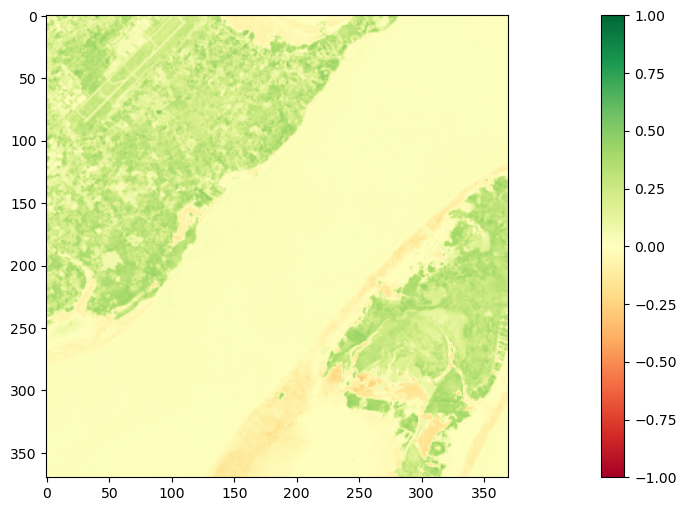


Label mangroves from 2000 data:


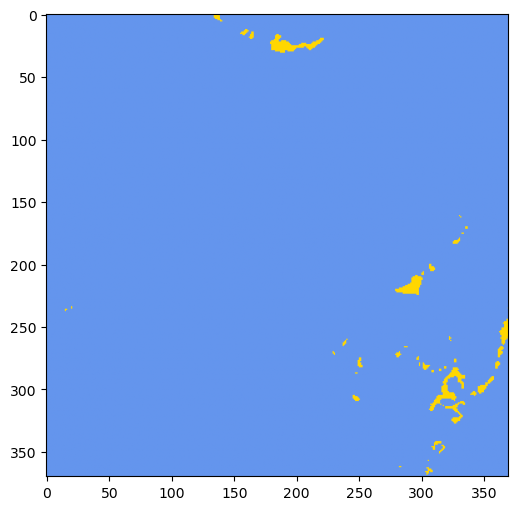

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
4279/4279 ━━━━━━━━━━━━━━━━━━━━ 2s 553us/step
Confusion matrix:
 [[ 19368 116259]
 [     4   1269]]

P-Score: 0.011, R-Score: 0.997
Accuracy: 0.151
f1: 0.021
              precision    recall  f1-score   support

           0       1.00      0.14      0.25    135627
           1       0.01      1.00      0.02      1273

    accuracy                           0.15    136900
   macro avg       0.51      0.57      0.14    136900
weighted avg       0.99      0.15      0.25    136900



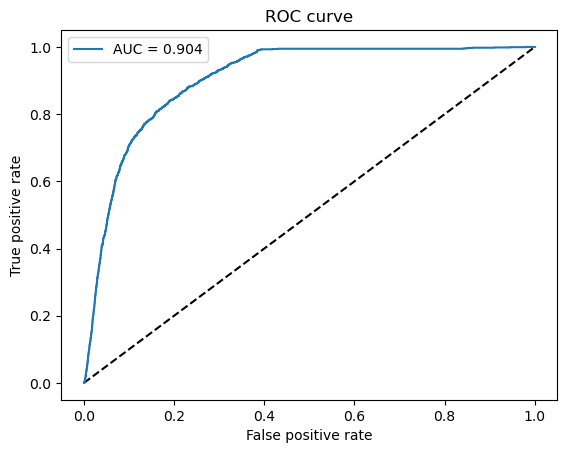


Predicted mangroves:


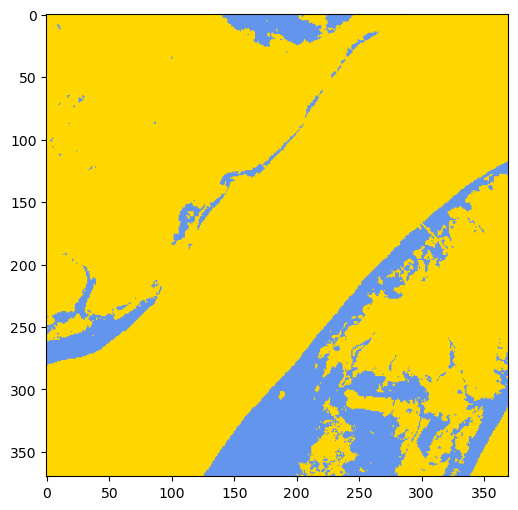


Difference between predicted and labeled mangroves:


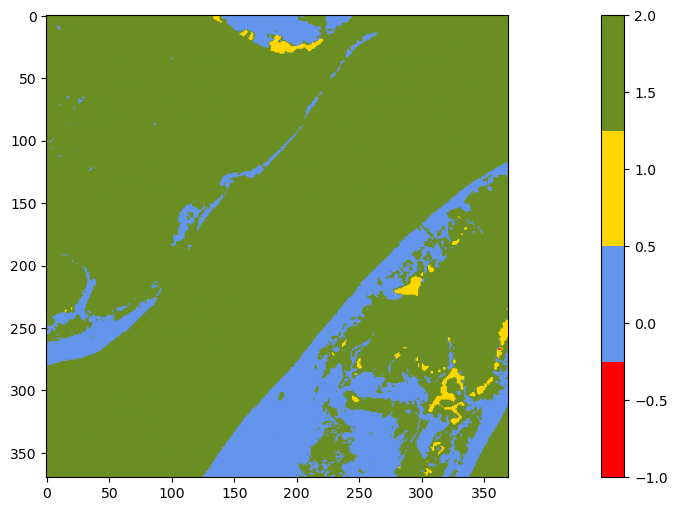

In [74]:
# apply model to new images
# predictOnImage(model, "/content/drive/MyDrive/MangroveClassification/Images/Florida_1_2020.tif")
# predictOnImage(model, "/content/drive/MyDrive/MangroveClassification/Images/Florida_3_2020.tif")
#predictOnImage(model, "/content/drive/MyDrive/MangroveClassification/Images/Brazil_1_2000.tif")




predictOnImage(model, "../SatelliteImages/Olango_2_2020_L8_L7ordered_scaled.tif")
#predictOnImage(model, "../SatelliteImages/Florida_1_2020.tif")


In [63]:
print('not now timeout!')

not now timeout!
